In [42]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import sklearn
import sklearn.model_selection
import sklearn.dummy
import sklearn.neighbors
import sklearn.ensemble
import torch

In [43]:
# read both the matches and the frames
match_df = pd.read_csv('../output/csv/lol-data-matches-fixed-duration.csv')
frame_df = pd.read_csv('../output/csv/lol-data-match-frames.csv')

# set the index of the match id
match_df = match_df.set_index('match_id')

# Drop the columns we do not need
match_df.drop(labels=['count','division','patch','region','first_rift_herald'], axis=1, inplace=True)

# Fill all values that are not filled out
match_df.fillna(0, inplace=True)

# Remove any matches with no winning team
match_df = match_df[match_df.winning_team!=0]

# Change the IDs of blue side and red side to 1 and -1, respectively
match_df.replace({
    'winning_team': {100: 1, 200: -1},
    'first_champion': {100: 1, 200: -1},
    'first_tower': {100: 1, 200: -1},
    'first_inhibitor': {100: 1, 200: -1},
    'first_baron': {100: 1, 200: -1},
    'first_dragon': {100: 1, 200: -1},
}, inplace=True)

# Reinterpret all values as int32s
match_df = match_df.astype({
    'winning_team': 'int32',
    'first_champion': 'int32',
    'first_tower': 'int32',
    'first_inhibitor': 'int32',
    'first_baron': 'int32',
    'first_dragon': 'int32',
})
match_df

,tier,game_duration,winning_team,first_champion,first_tower,first_inhibitor,first_baron,first_dragon
match_id,,,,,,,,
EUW1_5479661889,BRONZE,1797,1,1,1,1,1,1
EUW1_5479575964,BRONZE,1719,1,1,-1,1,0,1
EUW1_5479499524,BRONZE,1352,-1,-1,-1,-1,0,1
EUW1_5479492935,BRONZE,1647,-1,-1,1,-1,0,-1
EUW1_5479357161,BRONZE,1509,-1,-1,-1,-1,0,-1
...,...,...,...,...,...,...,...,...
EUW1_5544360421,GRANDMASTERS,1928,-1,1,-1,-1,-1,1
EUW1_5544335270,GRANDMASTERS,1101,-1,-1,-1,0,0,-1
EUW1_5544282724,GRANDMASTERS,1788,1,-1,1,1,1,-1


In [44]:
# Merge the match dataframe and the frame dataframe into one common table
df = match_df.merge(frame_df,left_on='match_id', right_on='match_id').set_index('match_id')
df





,tier,game_duration,winning_team,first_champion,first_tower,first_inhibitor,first_baron,first_dragon,count,frame,...,red_total_kills,red_total_gold,red_total_cs,red_total_damage,red_towers,red_plates,red_inhibitors,red_barons,red_dragons,red_rift_heralds
match_id,,,,,,,,,,,,,,,,,,,,,
EUW1_5479661889,BRONZE,1797,1,1,1,1,1,1,80697,0,...,0,2500,0,0,0,0,0,0,0,0
EUW1_5479661889,BRONZE,1797,1,1,1,1,1,1,80698,1,...,0,2500,0,0,0,0,0,0,0,0
EUW1_5479661889,BRONZE,1797,1,1,1,1,1,1,80699,2,...,0,2889,13,323,0,0,0,0,0,0
EUW1_5479661889,BRONZE,1797,1,1,1,1,1,1,80700,3,...,0,4423,53,1785,0,0,0,0,0,0
EUW1_5479661889,BRONZE,1797,1,1,1,1,1,1,80701,4,...,0,5701,79,2828,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
EUW1_5543889504,GRANDMASTERS,1461,-1,-1,1,-1,-1,-1,824350,21,...,27,48140,724,52148,2,11,0,0,3,1
EUW1_5543889504,GRANDMASTERS,1461,-1,-1,1,-1,-1,-1,824351,22,...,27,52429,758,61645,2,11,0,1,3,1
EUW1_5543889504,GRANDMASTERS,1461,-1,-1,1,-1,-1,-1,824352,23,...,32,54304,773,69206,2,11,0,1,3,1


In [45]:
## Here we train a dummy classifier to compare performance

def train_dummy_classifier(X, y):
    X_trn, X_tst, y_trn, y_tst = sklearn.model_selection.train_test_split(X, y, test_size=0.33, random_state=0)
    dummy_clf = sklearn.dummy.DummyClassifier(strategy='uniform', random_state=0)
    # Scale the data with MinMax to avoid negative values
    scaler = sklearn.preprocessing.MinMaxScaler()
    scaler.fit(X_trn)
    X_trn = scaler.transform(X_trn)
    X_tst = scaler.transform(X_tst)

    dummy_clf.fit(X_trn,y_trn)
    print(dummy_clf.score(X_tst, y_tst))

In [46]:
# Loop created to go through every frame in the data set. 
# For each frame, pick all corresponding data points, and 
# train both the neural network and the dummy classifier
# with it
current_frame = 25

print("TRAINING ON FRAME #%i" % current_frame)
# Get the values of X and y for a given frame
X = df[df.frame==current_frame][[
    'blue_total_kills',
    'blue_total_gold',
    'blue_total_cs',
    'blue_total_damage',
    'blue_towers', 
    'blue_plates',
    'blue_inhibitors', 
    'blue_barons', 
    'blue_dragons', 
    'blue_rift_heralds',
    'red_total_kills', 
    'red_total_gold', 
    'red_total_cs', 
    'red_total_damage',
    'red_towers', 
    'red_plates', 
    'red_inhibitors', 
    'red_barons',
    'red_dragons', 
    'red_rift_heralds',
]].values
y = df[df.frame==current_frame]['winning_team'].values

# Convert -1 and +1 to 0 and 1 for the tensors to work
y = np.interp(y, (-1,+1), (0, 1)).astype(np.int32)

# Two things occur here:
# 1. Normalize the data from values to a distribution [0,1] in l1 norm
#    e.g if Red side has 11 kill, and Blue has 9, we represent it as
#        0.55 and 0.45, respectively.
# 2. Collapse each blue features to their red features by subtracting them
#    e.g for ourprevious example, subtracting blue from red would result
#        to having 0.55-0.45 = 0.1. Hence a 10% advantage for blue
#        FIXME: could be an arbitrary x[0,:] - 0.5 to avoid doubling up
def combine(x):
    x = sklearn.preprocessing.normalize(x.reshape(2,10), norm='l1', axis=0)
    return x.reshape(20)
# Normalize the data to have 10 features 
# corresponding to a better comparison.
X = np.apply_along_axis(combine, 1, X)


TRAINING ON FRAME #25


In [47]:
#Split data
X_trn, X_tst, y_trn, y_tst = sklearn.model_selection.train_test_split(X, y, test_size=0.4)

In [48]:
def score_estimators(X, y, estimators):
    """Scores each estimator on (X, y), returning a list of scores."""
    # Your implementation here. Aim for 1-4 lines.
    scores = np.zeros_like(estimators)
    for x in range(len(estimators)):
        scores[x] = sklearn.metrics.accuracy_score(y, estimators[x].predict(X))
    return scores

In [49]:
def plot_estimator_scores(estimators, param_name, param_vals):
    """
    Plots the training, validation, and testing scores of a list of estimators,
    where `param_name` and `param_vals` are the same as for `train_estimators`.
    The estimator with best validation score will be highlighted with an 'x'.
    """
    # Your implementation here. Use as many lines as you need
    plt.figure()
    X = np.arange(0, len(param_vals))
    trn_scores = score_estimators(X_trn, y_trn, estimators)
    tst_scores = score_estimators(X_tst, y_tst, estimators)
    index = np.argmin(trn_scores - tst_scores)
    print(tst_scores[index])
    plt.title(estimators[0].__class__.__name__ + " score vs " + param_name)
    plt.xlabel(param_name)
    plt.ylabel("score")
    plt.ylim(0.0, 1.05)
    plt.scatter(X[index], tst_scores[index], marker='x', color='black', s=200)
    plt.plot(X, trn_scores, marker='o', color='green', markerfacecolor='green', label="train")
    plt.plot(X, tst_scores, marker='o', color='red', markerfacecolor='red', label="test")
    plt.text(0, 0.4,
             "Optimal Test Accuracy = %.2f%% with %s = %d " % (tst_scores[index] * 100, param_name, param_vals[index]))
    plt.legend()
    plt.xticks(X, param_vals)

In [50]:

def train_estimators(X, y, estimator_type, param_name, param_vals, **kwargs):
    estimators = [0 for i in range(len(param_vals))]
    for x in range(len(param_vals)):
        estimators[x] = estimator_type(**{param_name: param_vals[x]}, **kwargs).fit(X, y)
        # Training DecisionTreeClassifier(max_depth=1, random_state=0, splitter='random')...
        print("Training " + estimator_type.__name__ + "(" + param_name + "=%d " % param_vals[x] + " {0}={1} ".format(
            kwargs.keys(), kwargs.values()))
    return estimators

In [51]:
def train_kNN_estimators(X, y):
    #X_trn, X_tst, y_trn, y_tst = sklearn.model_selection.train_test_split(X, y, test_size=0.4)

    param_vals = [1, 5, 10, 15, 20]

    knn_estimators = train_estimators(X_trn, y_trn, sklearn.neighbors.KNeighborsClassifier, 'n_neighbors',
                                      param_vals=param_vals)

    plot_estimator_scores(knn_estimators, param_name='n_neighbors', param_vals=param_vals)



In [52]:

def train_random_forests(X, y):
    X_trn, X_tst, y_trn, y_tst = sklearn.model_selection.train_test_split(X, y, test_size=0.33, random_state=0)
    scaler = sklearn.preprocessing.MinMaxScaler()
    X_trn = scaler.fit_transform(X_trn)
    X_tst = scaler.fit_transform(X_tst)
    estimator = np.arange(1, 6) * 50
    depths = np.arange(1, 6) * 5
    estimators_meshed, depths_meshed = np.meshgrid(estimator, depths)

    trn_scores = np.arange(0, 25, dtype=float)
    tst_scores = np.arange(0, 25, dtype=float)
    X_axis = np.arange(0, 25)
    para_vals = np.array(
        ["50:5", "50:10", "50:15", "50:20", "50:25", "100:5", "100:10", "100:15", "100:20", "100:25", "150:5", "150:10",
         "150:15", "150:20", "150:25", "200:5", "200:10", "200:15", "200:20", "200:25", "250:5", "250:10", "250:15",
         "250:20", "250:25"])
    for i in range(5):
        for j in range(5):
            random_forest_model = sklearn.ensemble.RandomForestClassifier(n_estimators=estimators_meshed[j][i],
                                                                          max_depth=depths_meshed[j][i],
                                                                          random_state=0).fit(X_trn, y_trn)
            trn_scores[i * 5 + j] = sklearn.metrics.accuracy_score(y_trn, random_forest_model.predict(X_trn))
            print("Training Accuracy: %.2f %% with estimators = %d , depth = %d \n" % (
                trn_scores[i * 5 + j] * 100, estimators_meshed[j][i], depths_meshed[j][i]))
            tst_scores[i * 5 + j] = sklearn.metrics.accuracy_score(y_tst, random_forest_model.predict(X_tst))
            print("Test Accuracy: %.2f %% with estimators = %d , depth = %d \n" % (
                tst_scores[i * 5 + j] * 100, estimators_meshed[j][i], depths_meshed[j][i]))
    plt.figure()
    plt.title("Random Forests score vs estimators : depth")
    plt.xlabel("estimators : depth")
    plt.ylabel("score")
    plt.ylim(0.0, 1.05)
    index = np.argmin(trn_scores - tst_scores)
    plt.scatter(X_axis[index], trn_scores[index], marker='x', color='black', s=200)
    plt.plot(X_axis, trn_scores, marker='o', color='green', markerfacecolor='green', label="train")
    plt.plot(X_axis, tst_scores, marker='o', color='red', markerfacecolor='red', label="test")
    plt.legend()
    plt.text(0, 0.4,
             "Optimal Test Accuracy = %.2f%% with estimators : depth = %s " % (tst_scores[index] * 100, para_vals[index]))
    plt.xticks(X_axis, para_vals, fontsize=5)


In [55]:
## This is the neural network trained in Lab 8

def train_neural_network(X, y):
    # Split the data 2/3 to 1/3
    X_trn, X_tst, y_trn, y_tst = sklearn.model_selection.train_test_split(X, y, test_size=0.33, random_state=0)
    # Scale the data with MinMax to avoid negative values
    print(X_trn.shape)
    scaler = sklearn.preprocessing.MinMaxScaler()
    scaler.fit(X_trn)
    X_trn = scaler.transform(X_trn)
    X_tst = scaler.transform(X_tst)

    # Tensors setup
    X_trn_torch = torch.tensor(X_trn, dtype=torch.float32)
    y_trn_torch = torch.tensor(y_trn, dtype=torch.int64)
    X_tst_torch = torch.tensor(X_tst, dtype=torch.float32)
    y_tst_torch = torch.tensor(y_tst, dtype=torch.int64)

    torch.manual_seed(0) # Ensure model weights initialized with same random numbers

    # Create an object that holds a sequence of layers and activation functions
    model = torch.nn.Sequential(
        torch.nn.Linear(20, 10),   # Applies Wx+b from 10 dimensions down to 2
        torch.nn.ReLU(),
        torch.nn.Linear(10,2)
    )

    # Create an object that can compute "negative log likelihood of a softmax"
    loss = torch.nn.CrossEntropyLoss()

    # Use stochastic gradient descent to train the model
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)

    # Use 100 training samples at a time to compute the gradient.
    batch_size = 200

    # Make 10 passes over the training data, each time using batch_size samples to compute gradient
    num_epoch = 10
    next_epoch = 1

    for epoch in range(next_epoch, next_epoch+num_epoch):
        # Make an entire pass (an 'epoch') over the training data in batch_size chunks
        for i in range(0, len(X_trn), batch_size):        
            X_cur = X_trn_torch[i:i+batch_size]     # Slice out a mini-batch of features
            y_cur = y_trn_torch[i:i+batch_size]     # Slice out a mini-batch of targets
            
            y_pred = model(X_cur)                   # Make predictions (final-layer activations)
            l = loss(y_pred, y_cur)                 # Compute loss with respect to predictions
            
            model.zero_grad()                   # Reset all gradient accumulators to zero (PyTorch thing)
            l.backward()                        # Compute gradient of loss wrt all parameters (backprop!)
            optimizer.step()                    # Use the gradients to take a step with SGD.
            
        print("Epoch %2d: loss on final training batch: %.4f" % (epoch, l.item()))
        
    print("Epoch %2d: loss on test set: %.4f" % (epoch, loss(model(X_tst_torch), y_tst_torch)))
    next_epoch = epoch+1

Training Accuracy: 83.15 % with estimators = 50 , depth = 5 

Test Accuracy: 82.46 % with estimators = 50 , depth = 5 

Training Accuracy: 88.67 % with estimators = 50 , depth = 10 

Test Accuracy: 82.25 % with estimators = 50 , depth = 10 

Training Accuracy: 98.01 % with estimators = 50 , depth = 15 

Test Accuracy: 81.85 % with estimators = 50 , depth = 15 

Training Accuracy: 99.89 % with estimators = 50 , depth = 20 

Test Accuracy: 82.08 % with estimators = 50 , depth = 20 

Training Accuracy: 99.96 % with estimators = 50 , depth = 25 

Test Accuracy: 81.71 % with estimators = 50 , depth = 25 

Training Accuracy: 83.17 % with estimators = 100 , depth = 5 

Test Accuracy: 82.64 % with estimators = 100 , depth = 5 

Training Accuracy: 88.83 % with estimators = 100 , depth = 10 

Test Accuracy: 82.56 % with estimators = 100 , depth = 10 

Training Accuracy: 98.17 % with estimators = 100 , depth = 15 

Test Accuracy: 82.03 % with estimators = 100 , depth = 15 

Training Accuracy: 99.

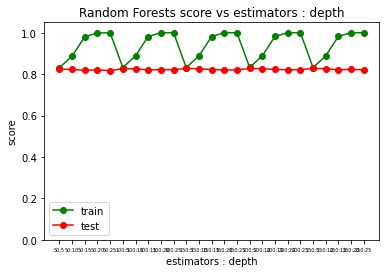

In [54]:
#train_neural_network(X, y)
#train_kNN_estimators(X, y)
train_random_forests(X, y)
# train_dummy_classifier(X, y)